In [15]:
from transformers import pipeline
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import nltk
from sklearn.linear_model import LogisticRegression
import spacy
import unidecode
from word2number import w2n
import contractions
from bs4 import BeautifulSoup
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing, metrics
from sklearn.model_selection import train_test_split

from lime import lime_text
import gensim
import gensim.downloader as gensim_api
from tensorflow.keras import models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K
import transformers

In [16]:
real_news = pd.read_csv('./datasets/real_news/real_news.csv', index_col="id").iloc[:, :7]
fake_news = pd.read_csv('./datasets/fake_news/fake_news.csv', index_col="id", encoding='latin1').iloc[:, :12]
real_news.fillna(value="", axis=0, inplace=True)
fake_news.fillna(value="", axis=0, inplace=True)
real_news['label'] = "real"
fake_news['label'] = 'fake'
real_news['text_clean'] = None
fake_news['text_clean'] = None

### Data Visualization

In [3]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import warnings
warnings.filterwarnings("ignore")

1401647


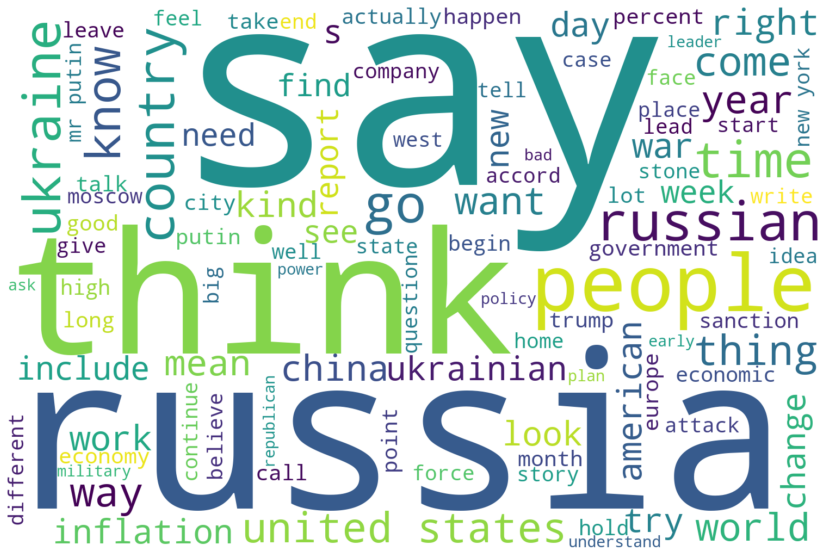

In [6]:
# text = " ".join(article_text for article_text in real_news['text'])

text = ""
for i in range(len(real_news)):
    text += " ".join(article_text for article_text in real_news['text_clean'].iloc[i])
print(len(text))

wordcloud = WordCloud(max_words=100, background_color="white", width=1500, height=1000).generate(text)
# Display the generated image:
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

1440666


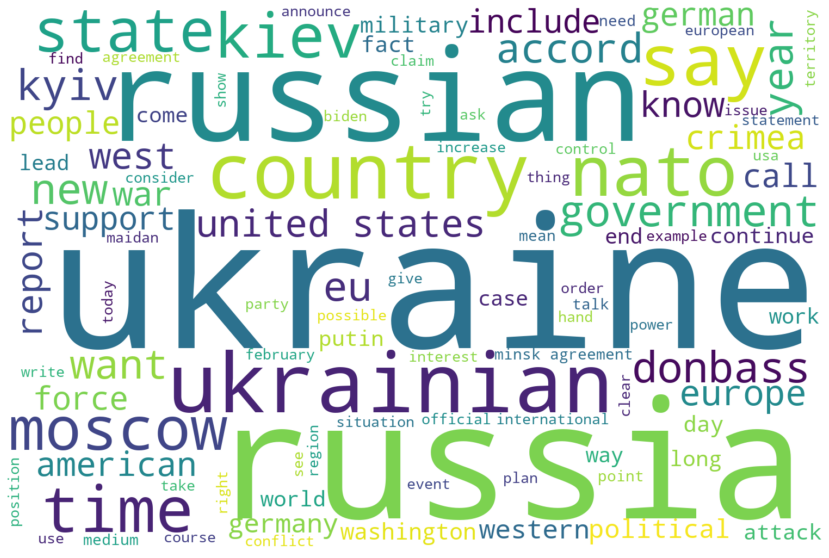

In [7]:
# text = " ".join(article_text for article_text in fake_news['text'])

text = ""
for i in range(len(fake_news)):
    text += " ".join(article_text for article_text in fake_news['text_clean'].iloc[i])
print(len(text))

wordcloud = WordCloud(max_words=100, background_color="white", width=1500, height=1000).generate(text)
# Display the generated image:
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [10]:
# text = " ".join(article_text for article_text in real_news['text'])

text = ""
for i in range(len(real_news)):
    text += " ".join(article_text for article_text in real_news['text_clean'].iloc[i])
print(len(text))

wordcloud = WordCloud(background_color="white", width=1500, height=1000).generate(text)
real_words = wordcloud.process_text(text)


# text = " ".join(article_text for article_text in fake_news['text'])

text = ""
for i in range(len(fake_news)):
    text += " ".join(article_text for article_text in fake_news['text_clean'].iloc[i])
print(len(text))

wordcloud = WordCloud(background_color="white", width=1500, height=1000).generate(text)
fake_words = wordcloud.process_text(text)

1401647
1440666


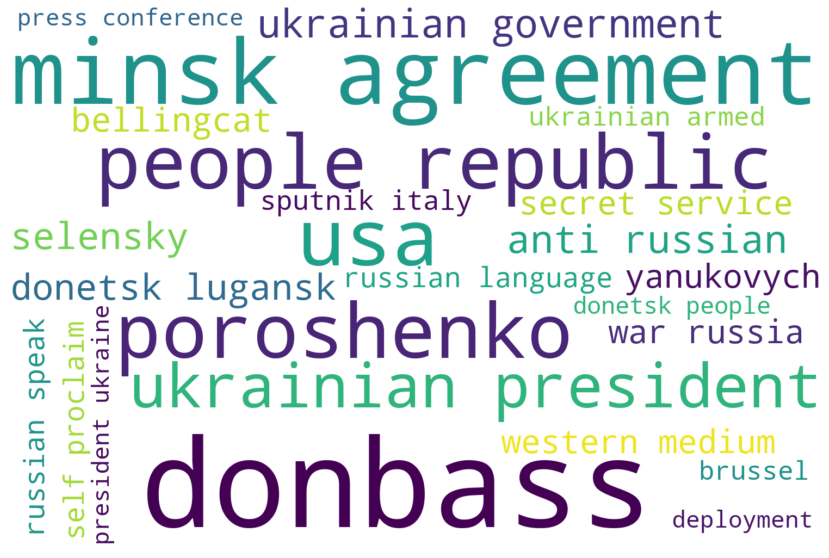

In [13]:
difference_words = set(fake_words) - set(real_words)

difference_dict = {}
for different_word in difference_words:
    difference_dict[different_word] = fake_words[different_word]
    
wordcloud = WordCloud(max_words=25, background_color="white", width=1500, height=1000).generate_from_frequencies(difference_dict)
# Display the generated image:
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('fake_news.png')
plt.show()

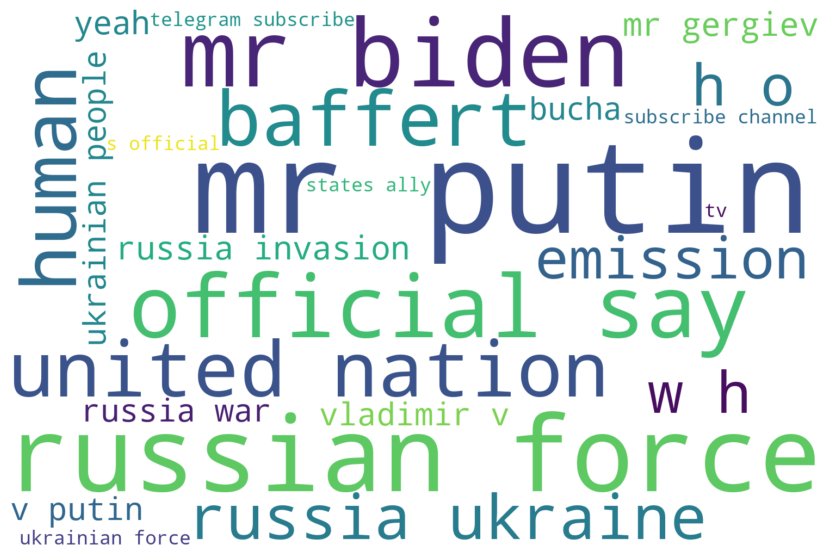

In [14]:
difference_words = set(real_words) - set(fake_words)
difference_dict = {}
for different_word in difference_words:
    difference_dict[different_word] = real_words[different_word]
    
wordcloud = WordCloud(max_words=25, background_color="white", width=1500, height=1000).generate_from_frequencies(difference_dict)
# Display the generated image:
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('real_news.png')
# plt.show()

### Data Cleaning

In [59]:
stop_words = set(nltk.corpus.stopwords.words('english'))

# load spacy model, can be "en_core_web_sm" as well
nlp = spacy.load('en_core_web_md')

# exclude words from spacy stopwords list
deselect_stop_words = ['no', 'not']
for w in deselect_stop_words:
    nlp.vocab[w].is_stop = False

def strip_html_tags(text):
    """remove html tags from text"""
#     print(text)
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text(separator=" ")
    return stripped_text

def remove_whitespace(text):
    """remove extra whitespaces from text"""
    text = text.strip()
    return " ".join(text.split())

def remove_accented_chars(text):
    """remove accented characters from text, e.g. café"""
    text = unidecode.unidecode(text)
    return text

def expand_contractions(text):
    """expand shortened words, e.g. don't to do not"""
    text = contractions.fix(text)
    return text

def text_preprocessing(text, accented_chars=True, contractions=True, 
                       convert_num=True, extra_whitespace=True, 
                       lemmatization=True, lowercase=True, punctuations=True,
                       remove_html=False, remove_num=False, special_chars=True, 
                       stop_words=True):
    """preprocess text with default option set to true for all steps"""
    if remove_html == True: #remove html tags
        text = strip_html_tags(text)
    if extra_whitespace == True: #remove extra whitespaces
        text = remove_whitespace(text)
    if accented_chars == True: #remove accented characters
        text = remove_accented_chars(text)
    if contractions == True: #expand contractions
        text = expand_contractions(text)
    if lowercase == True: #convert all characters to lowercase
        text = text.lower()

    doc = nlp(text) #tokenise text

    clean_text = []
    
    for token in doc:
        flag = True
        edit = token.text
        # remove stop words
        if stop_words == True and token.is_stop and token.pos_ != 'NUM': 
            flag = False
        # remove punctuations
        if punctuations == True and token.pos_ == 'PUNCT' and flag == True: 
            flag = False
        # remove special characters
        if special_chars == True and token.pos_ == 'SYM' and flag == True: 
            flag = False
        # remove numbers
        if remove_num == True and (token.pos_ == 'NUM' or token.text.isnumeric()) \
        and flag == True:
            flag = False
        # convert number words to numeric numbers
        if convert_num == True and token.pos_ == 'NUM' and flag == True:
            try:
                edit = w2n.word_to_num(token.text)
            except(ValueError):
                pass
        # convert tokens to base form
        elif lemmatization == True and token.lemma_ != "-PRON-" and flag == True:
            edit = token.lemma_
        # append tokens edited and not removed to list 
        if edit != "" and flag == True:
            clean_text.append(edit)        
    return clean_text

for i in range(len(real_news)):
#     real_news['title'].iloc[i] = text_preprocessing(real_news['title'].iloc[i])
#     real_news['description'].iloc[i] = text_preprocessing(real_news['description'].iloc[i])
    real_news['text_clean'].iloc[i] = text_preprocessing(real_news['text'].iloc[i])
    
for i in range(len(fake_news)):
#     fake_news['title'].iloc[i] = text_preprocessing(fake_news['title'].iloc[i])
#     fake_news['description'].iloc[i] = text_preprocessing(fake_news['description'].iloc[i])
    fake_news['text_clean'].iloc[i] = text_preprocessing(fake_news['text'].iloc[i])

In [60]:
print(fake_news['text'].iloc[27])

According to his Facebook page, Dmitry Yarosh, the former head of the Right Sector, has been appointed adviser to the Supreme Commander of the Armed Forces of Ukraine. Yarosh is one of the most notorious Ukrainian nationalists. Dmitri Jarosch, born in 1971, was a co-founder of the neo-Nazi organization "Trident" in 1994, which he led from 1996 to 1999 and which was transferred to the Right Sector in 2013. Until November 2015 he was the leader of this most notorious Ukrainian neo-Nazi formation. The Right Sector provided the most violent demonstrators during the Maidan, easily recognizable by their red and black armbands, and even before the coup in late February 2014 there were reports of torture in the Kiev Trade Union House, which the nationalists had stormed and made their headquarters.

Throughout the course of the Ukrainian civil war, the Right Sector plays a fatal role. It was Yarosh's announcement that he would storm Crimea with 5,000 men that triggered the decision on Crimea's 

In [61]:
print(fake_news['text_clean'].iloc[27])

['accord', 'facebook', 'page', 'dmitry', 'yarosh', 'head', 'right', 'sector', 'appoint', 'adviser', 'supreme', 'commander', 'armed', 'force', 'ukraine', 'yarosh', 1, 'notorious', 'ukrainian', 'nationalist', 'dmitri', 'jarosch', 'bear', 1971, 'co', '-', 'founder', 'neo', '-', 'nazi', 'organization', 'trident', 1994, 'lead', 1996, 1999, 'transfer', 'right', 'sector', 2013, 'november', 2015, 'leader', 'notorious', 'ukrainian', 'neo', '-', 'nazi', 'formation', 'right', 'sector', 'provide', 'violent', 'demonstrator', 'maidan', 'easily', 'recognizable', 'red', 'black', 'armband', 'coup', 'late', 'february', 2014, 'report', 'torture', 'kiev', 'trade', 'union', 'house', 'nationalist', 'storm', 'headquarter', 'course', 'ukrainian', 'civil', 'war', 'right', 'sector', 'play', 'fatal', 'role', 'yarosh', 'announcement', 'storm', 'crimea', '5,000', 'man', 'trigger', 'decision', 'crimea', 'referendum', 'secession', 'ukraine', 'march', 2014, 'slogan', 'right', 'sector', 'time', 'crimea', 'remain', 'uk

In [57]:
for i in range(len(fake_news['text_clean'].iloc[27])):
    if type(fake_news['text_clean'].iloc[27][i]) != str:
        fake_news['text_clean'].iloc[27][i] = str(fake_news['text_clean'].iloc[27][i])

In [ ]:
real_news.head()

In [ ]:
fake_news.head()

In [22]:
total_word_count_real_news = 0
total_word_count_real_news = 0

for i in range(len(real_news)):
    total_word_count_real_news += len(real_news['text_clean'].iloc[i])
for i in range(len(fake_news)):
    total_word_count_real_news += len(fake_news['text_clean'].iloc[i])

print(total_word_count_real_news/len(real_news))
print(total_word_count_real_news/len(fake_news))
print((total_word_count_real_news + total_word_count_real_news)/(len(fake_news) + len(real_news)))

983.9319899244332
964.4962962962964
974.1172069825436


In [62]:

X = pd.concat([real_news, fake_news])
y = X['label']

X_train__, X_test__, y_train, y_test = train_test_split(X, y, test_size=0.2)

# print(len(real_news_train), len(real_news_test), len(fake_news_train), len(fake_news_test))

dtf_train = X_train__
dtf_test = X_test__

print(len(dtf_train), len(dtf_test))

641 161


In [63]:
# Train the word2vec model
w2v_model = gensim.models.Word2Vec(X_train__['text_clean'],
                                   vector_size=100,
                                   window=10,
                                   min_count=2)

In [64]:
# Find the most similar words to "king" based on word vectors from our trained model
w2v_model.wv.most_similar('russia')

[('security', 0.9327285885810852),
 ('nato', 0.9308245778083801),
 ('moscow', 0.9159192442893982),
 ('ally', 0.9128455519676208),
 ('regroup', 0.9071130752563477),
 ('invasion', 0.9041013121604919),
 ('ukraine', 0.9032572507858276),
 ('array', 0.8964338302612305),
 ('kamikaze', 0.8929726481437683),
 ('firepower', 0.8916618824005127)]

In [65]:
words = set(w2v_model.wv.index_to_key )
X_train_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])
                         for ls in X_train__['text_clean']])
X_test_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])
                         for ls in X_test__['text_clean']])

In [66]:
# Compute sentence vectors by averaging the word vectors for the words contained in the sentence
X_train_vect_avg = []
for v in X_train_vect:
    if v.size:
        X_train_vect_avg.append(v.mean(axis=0))
    else:
        X_train_vect_avg.append(np.zeros(100, dtype=float))
        
X_test_vect_avg = []
for v in X_test_vect:
    if v.size:
        X_test_vect_avg.append(v.mean(axis=0))
    else:
        X_test_vect_avg.append(np.zeros(100, dtype=float))

In [67]:
# Are our sentence vector lengths consistent?
for i, v in enumerate(X_train_vect_avg):
    print(len(X_train__['text_clean'].iloc[i]), len(v))

130 100
115 100
107 100
310 100
118 100
486 100
159 100
169 100
613 100
38 100
496 100
89 100
130 100
356 100
115 100
2368 100
115 100
130 100
77 100
826 100
94 100
1011 100
678 100
359 100
383 100
176 100
1199 100
306 100
93 100
144 100
136 100
341 100
732 100
517 100
502 100
1298 100
40 100
405 100
321 100
170 100
967 100
161 100
286 100
804 100
850 100
867 100
456 100
148 100
711 100
102 100
155 100
907 100
167 100
254 100
145 100
309 100
88 100
382 100
1012 100
705 100
83 100
532 100
277 100
169 100
414 100
294 100
307 100
554 100
144 100
197 100
409 100
169 100
961 100
470 100
183 100
149 100
780 100
125 100
130 100
337 100
639 100
107 100
115 100
522 100
31 100
194 100
86 100
2355 100
208 100
1330 100
829 100
157 100
512 100
1450 100
459 100
408 100
144 100
432 100
592 100
396 100
264 100
512 100
1126 100
34 100
222 100
77 100
167 100
135 100
2012 100
316 100
289 100
107 100
151 100
2248 100
637 100
335 100
398 100
367 100
336 100
426 100
92 100
673 100
334 100
1574 100
626 100
1

In [68]:
print(X_train_vect_avg[0])

[-0.26497123  0.28601     0.22674389 -0.21003418  0.1028809  -0.59386253
  0.2945984   0.90204537 -0.34620368 -0.29201    -0.44846287 -0.73033196
 -0.09447441  0.06961167  0.559634   -0.69316137  0.509705   -0.48886767
 -0.11192179 -0.9944737   0.4288599  -0.01709927  0.36658138 -0.15031557
 -0.26580966  0.2867449  -0.22455004 -0.31261188 -0.54763067  0.22098823
  0.60998327  0.24205863 -0.35908455 -0.2690111  -0.3753298   0.58915883
  0.05000014 -0.1350289  -0.5243878  -0.8100593   0.05146611 -0.4152983
 -0.00519707  0.13942713  0.3077516  -0.49231148 -0.24306573 -0.15364914
  0.10109469  0.36467525  0.57470787 -0.385631   -0.19497474 -0.12028651
 -0.6538265   0.21274157  0.68617713 -0.3110306  -0.51283765 -0.20283888
  0.07075457  0.25245303 -0.41161737  0.03176299 -0.44209158  0.34133315
  0.5193022   0.21618667 -0.5717307   0.40408447 -0.1442986   0.2219992
  0.37690264 -0.10743947  0.18071784  0.35987616  0.08629218  0.15323228
 -0.24005647  0.2756119  -0.22370684 -0.19054721 -0.1

In [69]:
# Instantiate and fit a basic Random Forest model on top of the vectors
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf_model = rf.fit(X_train_vect_avg, y_train.values.ravel())

In [70]:
# Use the trained model to make predictions on the test data
y_pred = rf_model.predict(X_test_vect_avg)

In [71]:
from sklearn.metrics import precision_score, recall_score
precision = precision_score(y_test, y_pred, pos_label='real')
recall = recall_score(y_test, y_pred, pos_label='real')
print('Precision: {} / Recall: {} / Accuracy: {}'.format(
    round(precision, 3), round(recall, 3), round((y_pred==y_test).sum()/len(y_pred), 3)))

Precision: 0.923 / Recall: 0.882 / Accuracy: 0.919


In [72]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression().fit(X_train_vect_avg, y_train.values.ravel())
y_pred = clf.predict(X_test_vect_avg)
precision = precision_score(y_test, y_pred, pos_label='real')
recall = recall_score(y_test, y_pred, pos_label='real')
print('Precision: {} / Recall: {} / Accuracy: {}'.format(
    round(precision, 3), round(recall, 3), round((y_pred==y_test).sum()/len(y_pred), 3)))

Precision: 0.868 / Recall: 0.868 / Accuracy: 0.888


# Distil-BERT

In [ ]:
# txt = "bank river"
# ## bert tokenizer
# tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
# ## bert model
# nlp = transformers.TFBertModel.from_pretrained('bert-base-uncased')
# ## return hidden layer with embeddings
# input_ids = np.array(tokenizer.encode(txt))[None,:]  
# embedding = nlp(input_ids)
# embedding[0][0]

In [73]:
## distil-bert tokenizer
tokenizer = transformers.AutoTokenizer.from_pretrained('distilbert-base-uncased', use_fast=False, do_lower_case=True)
# tokenizer = transformers.AutoTokenizer.from_pretrained('bert-base-uncased', use_fast=False, do_lower_case=True)

In [74]:
corpus = dtf_train["text"]
# corpus = ['hello', 'what', 'some', 'body', 'to', 'lost', 'ukraine', 'russia', 'vladmir',
#           'war', 'weapon', 'nuclear', 'nazi', 'vlodmyr', 'zelensky', 'nato']
maxlen = 100

## add special tokens
maxqnans = np.int((maxlen-20)/2)
corpus_tokenized = ["[CLS] "+
             " ".join(tokenizer.tokenize(re.sub(r'[^\w\s]+|\n', '', 
             str(txt).lower().strip()))[:maxqnans])+
             " [SEP] " for txt in corpus]

## generate masks
masks = [[1]*len(txt.split(" ")) + [0]*(maxlen - len(
           txt.split(" "))) for txt in corpus_tokenized]
    
## padding
txt2seq = [txt + " [PAD]"*(maxlen-len(txt.split(" "))) if len(txt.split(" ")) != maxlen else txt for txt in corpus_tokenized]
    
## generate idx
idx = [tokenizer.encode(seq.split(" "))[:maxlen] for seq in txt2seq]

# print(idx)

## generate segments
segments = [] 
for seq in txt2seq:
    temp, i = [], 0
    for token in seq.split(" "):
        temp.append(i)
        if token == "[SEP]":
             i += 1
    segments.append(temp)
## feature matrix
# X_train = [np.asarray(idx, dtype='int32'), 
#            np.asarray(masks, dtype='int32'), 
#            np.asarray(segments, dtype='int32')]
X_train = [np.asarray(idx, dtype='int32'), 
           np.asarray(masks, dtype='int32')]

In [75]:
i = 0
print("txt: ", dtf_train["text"].iloc[0])
print("tokenized:", [tokenizer.convert_ids_to_tokens(idx) for idx in X_train[0][i].tolist()])
print("idx: ", X_train[0][i], len(X_train[0][i]))
print("mask: ", X_train[1][i], len(X_train[1][i]))
# print("segment: ", X_train[2][i])

txt:  The worry is that these territories will become the setting for a catastrophe, whether staged or accidental, that could lead to far wider violence. A stray shell, for example, might hit a residential building, or there could be a terrorist attack on fleeing refugees. Whatever the situation, Ukraine would be blamed, and Russia would have a pretext to invade.

Russia, despite repeated accusations from the West, says that it has no intention of invading, and that it simply wants its legitimate geopolitical interests respected.

On Sunday evening, the Ukrainian military issued a statement saying the Russian-backed separatists in the Luhansk region had opened fire with heavy artillery on their own capital city “with the goal of blaming the Ukrainian military.”

“In the absence of any aggressive action from the Ukrainian defenders, the occupiers themselves are blowing up infrastructure in the occupied territories and firing chaotically on towns,” the statement said. Russian news agenci

In [76]:
corpus = dtf_test["text"]
# corpus = ['hello', 'what', 'some', 'body', 'to', 'lost', 'ukraine', 'russia', 'vladmir',
#           'war', 'weapon', 'nuclear', 'nazi', 'vlodmyr', 'zelensky', 'nato']
maxlen = 100

## add special tokens
maxqnans = np.int((maxlen-20)/2)
corpus_tokenized = ["[CLS] "+
             " ".join(tokenizer.tokenize(re.sub(r'[^\w\s]+|\n', '', 
             str(txt).lower().strip()))[:maxqnans])+
             " [SEP] " for txt in corpus]

## generate masks
masks = [[1]*len(txt.split(" ")) + [0]*(maxlen - len(
           txt.split(" "))) for txt in corpus_tokenized]
    
## padding
txt2seq = [txt + " [PAD]"*(maxlen-len(txt.split(" "))) if len(txt.split(" ")) != maxlen else txt for txt in corpus_tokenized]
    
## generate idx
idx = [tokenizer.encode(seq.split(" "))[:maxlen] for seq in txt2seq]

# print(idx)

## generate segments
segments = [] 
for seq in txt2seq:
    temp, i = [], 0
    for token in seq.split(" "):
        temp.append(i)
        if token == "[SEP]":
             i += 1
    segments.append(temp)
## feature matrix
# X_train = [np.asarray(idx, dtype='int32'), 
#            np.asarray(masks, dtype='int32'), 
#            np.asarray(segments, dtype='int32')]
X_test = [np.asarray(idx, dtype='int32'), 
           np.asarray(masks, dtype='int32')]

In [90]:
i = 0
print("txt: \n\n", dtf_test["text"].iloc[0])
print("\n\ntokenized:\n\n", [tokenizer.convert_ids_to_tokens(idx) for idx in X_test[0][i].tolist()])
print("idx: ", X_test[0][i], len(X_test[0][i]))
print("mask: ", X_test[1][i], len(X_test[1][i]))
# print("segment: ", X_train[2][i])

txt: 

 A comedian close to the presidency of Ukraine. In fact, except for twists and turns, the actor and new entry in the political world Volodymyr Zelensky is the great favorite in the second round of the country's presidential elections. He knows he has this victory in his pocket and leaves the polling station showing the photographers his card: he violates the law and is fined. However, five years after Maidan's pro-Western revolution, Ukrainians still seem determined to turn the tables, preferring the 41-year-old to Petro Poroshenko , who at 53 is paying for not putting an end to the civil war and repeated scandals that have stained the political class.

Who is the favorite? Unimaginable, just a few weeks ago, the victory for Volodymyr Zelensky, which brings with it a new wave of the global anti-elite movement, is now considered a reality by many observers in Kiev. Largely ahead of the first round, scoring twice as high as his rival, Zelensky was given more than 70% of voting int

In [78]:
## inputs
idx = layers.Input((maxlen), dtype="int32", name="input_idx")
masks = layers.Input((maxlen), dtype="int32", name="input_masks")
## pre-trained bert with config
config = transformers.DistilBertConfig(dropout=0.2, 
           attention_dropout=0.2)
config.output_hidden_states = False
nlp = transformers.TFDistilBertModel.from_pretrained('distilbert-base-uncased', config=config)
bert_out = nlp(idx, attention_mask=masks)[0]
## fine-tuning
x = layers.GlobalAveragePooling1D()(bert_out)
x = layers.Dense(64, activation="relu")(x)
y_out = layers.Dense(len(np.unique(y_train)), 
                     activation='softmax')(x)
## compile
model = models.Model([idx, masks], y_out)
for layer in model.layers[:3]:
    layer.trainable = False
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer='adam', metrics=['accuracy'])
model.summary()

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_projector', 'activation_13', 'vocab_transform', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_idx (InputLayer)         [(None, 100)]        0           []                               
                                                                                                  
 input_masks (InputLayer)       [(None, 100)]        0           []                               
                                                                                                  
 tf_distil_bert_model (TFDistil  TFBaseModelOutput(l  66362880   ['input_idx[0][0]',              
 BertModel)                     ast_hidden_state=(N               'input_masks[0][0]']            
                                one, 100, 768),                                                   
                                 hidden_states=None                                           

In [91]:
## encode y
dic_y_mapping = {n:label for n,label in 
                 enumerate(np.unique(y_train))}
inverse_dic = {v:k for k,v in dic_y_mapping.items()}

y_train_ = np.array([inverse_dic[y] for y in y_train])
y_test_ = np.array([inverse_dic[y] for y in y_test])

## train
training = model.fit(x=X_train, y=y_train_, batch_size=32, 
                     epochs=100, shuffle=True, verbose=1)
## test
predicted_prob = model.predict(X_test)
predicted = [np.argmax(pred) for pred in 
             predicted_prob]

Epoch 1/100
21/21 [==============================] - 1s 66ms/step - loss: 0.1918 - accuracy: 0.9251
Epoch 2/100
21/21 [==============================] - 1s 67ms/step - loss: 0.1747 - accuracy: 0.9392
Epoch 3/100
21/21 [==============================] - 1s 65ms/step - loss: 0.1743 - accuracy: 0.9329
Epoch 4/100
21/21 [==============================] - 1s 64ms/step - loss: 0.1550 - accuracy: 0.9485
Epoch 5/100
21/21 [==============================] - 1s 64ms/step - loss: 0.1316 - accuracy: 0.9563
Epoch 6/100
21/21 [==============================] - 1s 66ms/step - loss: 0.1304 - accuracy: 0.9579
Epoch 7/100
21/21 [==============================] - 1s 61ms/step - loss: 0.1424 - accuracy: 0.9516
Epoch 8/100
21/21 [==============================] - 1s 61ms/step - loss: 0.1203 - accuracy: 0.9626
Epoch 9/100
21/21 [==============================] - 1s 61ms/step - loss: 0.1100 - accuracy: 0.9610
Epoch 10/100
21/21 [==============================] - 1s 60ms/step - loss: 0.0960 - accuracy: 0.9672

Accuracy: 0.89
Auc: 0.88
Detail:
              precision    recall  f1-score   support

           0       0.89      0.91      0.90        93
           1       0.88      0.85      0.87        68

    accuracy                           0.89       161
   macro avg       0.89      0.88      0.88       161
weighted avg       0.89      0.89      0.89       161



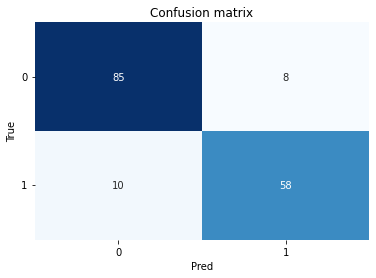

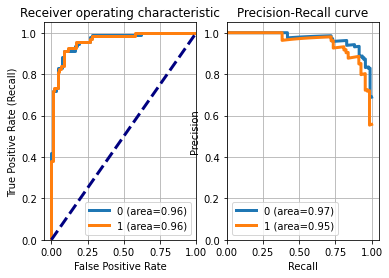

In [92]:
classes = np.unique(y_test_)
y_test_array = pd.get_dummies(y_test_, drop_first=False).values
    
## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test_, predicted)
auc = metrics.roc_auc_score(y_test_, predicted, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test_, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test_, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2)
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

# BERT

In [93]:
## bert tokenizer
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased', use_fast=False, do_lower_case=True)

In [94]:
corpus = dtf_train["text"]
maxlen = 100

## add special tokens
maxqnans = np.int((maxlen-20)/2)
corpus_tokenized = ["[CLS] "+
             " ".join(tokenizer.tokenize(re.sub(r'[^\w\s]+|\n', '', 
             str(txt).lower().strip()))[:maxqnans])+
             " [SEP] " for txt in corpus]

## generate masks
masks = [[1]*len(txt.split(" ")) + [0]*(maxlen - len(
           txt.split(" "))) for txt in corpus_tokenized]
    
## padding
txt2seq = [txt + " [PAD]"*(maxlen-len(txt.split(" "))) if len(txt.split(" ")) != maxlen else txt for txt in corpus_tokenized]
    
## generate idx
idx = [tokenizer.encode(seq.split(" "))[:maxlen] for seq in txt2seq]
    
## generate segments
segments = [] 
for seq in txt2seq:
    temp, i = [], 0
    for token in seq.split(" "):
        temp.append(i)
        if token == "[SEP]":
             i += 1
    segments.append(temp)
## feature matrix
X_train = [np.asarray(idx, dtype='int32'), 
           np.asarray(masks, dtype='int32'), 
           np.asarray(segments, dtype='int32')]

In [95]:
i = 0
print("txt: ", dtf_train["text"].iloc[0])
print("tokenized:", [tokenizer.convert_ids_to_tokens(idx) for idx in X_train[0][i].tolist()])
print("idx: ", X_train[0][i], len(X_train[0][i]))
print("mask: ", X_train[1][i], len(X_train[1][i]))
print("segment: ", X_train[2][i], len(X_train[2][i]))

txt:  The worry is that these territories will become the setting for a catastrophe, whether staged or accidental, that could lead to far wider violence. A stray shell, for example, might hit a residential building, or there could be a terrorist attack on fleeing refugees. Whatever the situation, Ukraine would be blamed, and Russia would have a pretext to invade.

Russia, despite repeated accusations from the West, says that it has no intention of invading, and that it simply wants its legitimate geopolitical interests respected.

On Sunday evening, the Ukrainian military issued a statement saying the Russian-backed separatists in the Luhansk region had opened fire with heavy artillery on their own capital city “with the goal of blaming the Ukrainian military.”

“In the absence of any aggressive action from the Ukrainian defenders, the occupiers themselves are blowing up infrastructure in the occupied territories and firing chaotically on towns,” the statement said. Russian news agenci

In [96]:
corpus = dtf_test["text"]
maxlen = 100

## add special tokens
maxqnans = np.int((maxlen-20)/2)
corpus_tokenized = ["[CLS] "+
             " ".join(tokenizer.tokenize(re.sub(r'[^\w\s]+|\n', '', 
             str(txt).lower().strip()))[:maxqnans])+
             " [SEP] " for txt in corpus]

## generate masks
masks = [[1]*len(txt.split(" ")) + [0]*(maxlen - len(
           txt.split(" "))) for txt in corpus_tokenized]
    
## padding
txt2seq = [txt + " [PAD]"*(maxlen-len(txt.split(" "))) if len(txt.split(" ")) != maxlen else txt for txt in corpus_tokenized]
    
## generate idx
idx = [tokenizer.encode(seq.split(" "))[:maxlen] for seq in txt2seq]
    
## generate segments
segments = [] 
for seq in txt2seq:
    temp, i = [], 0
    for token in seq.split(" "):
        temp.append(i)
        if token == "[SEP]":
             i += 1
    segments.append(temp)
## feature matrix
X_test = [np.asarray(idx, dtype='int32'), 
           np.asarray(masks, dtype='int32'), 
           np.asarray(segments, dtype='int32')]

In [97]:
i = 0
print("txt: ", dtf_test["text"].iloc[0])
print("tokenized:", [tokenizer.convert_ids_to_tokens(idx) for idx in X_test[0][i].tolist()])
print("idx: ", X_test[0][i], len(X_test[0][i]))
print("mask: ", X_test[1][i], len(X_test[1][i]))
print("segment: ", X_test[2][i], len(X_test[2][i]))

txt:  A comedian close to the presidency of Ukraine. In fact, except for twists and turns, the actor and new entry in the political world Volodymyr Zelensky is the great favorite in the second round of the country's presidential elections. He knows he has this victory in his pocket and leaves the polling station showing the photographers his card: he violates the law and is fined. However, five years after Maidan's pro-Western revolution, Ukrainians still seem determined to turn the tables, preferring the 41-year-old to Petro Poroshenko , who at 53 is paying for not putting an end to the civil war and repeated scandals that have stained the political class.

Who is the favorite? Unimaginable, just a few weeks ago, the victory for Volodymyr Zelensky, which brings with it a new wave of the global anti-elite movement, is now considered a reality by many observers in Kiev. Largely ahead of the first round, scoring twice as high as his rival, Zelensky was given more than 70% of voting inten

In [98]:
## inputs
idx = layers.Input((maxlen), dtype="int32", name="input_idx")
masks = layers.Input((maxlen), dtype="int32", name="input_masks")
segments = layers.Input((maxlen), dtype="int32", name="input_segments")

## pre-trained bert
config = transformers.BertConfig.from_pretrained("bert-base-uncased", output_hidden_states=True, dropout=0.2, 
           attention_dropout=0.2)
nlp = transformers.TFBertModel.from_pretrained("bert-base-uncased", config=config)

# nlp = transformers.TFBertModel.from_pretrained("bert-base-uncased")

bert_out = nlp([idx, masks, segments])[0]
# print(bert_out.shape)
print(bert_out)
## fine-tuning
x = layers.GlobalAveragePooling1D()(bert_out)
x = layers.Dense(64, activation="relu")(x)
y_out = layers.Dense(len(np.unique(y_train)), 
                     activation='softmax')(x)
## compile
model = models.Model([idx, masks, segments], y_out)
for layer in model.layers[:4]:
    layer.trainable = False
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer='adam', metrics=['accuracy'])
model.summary()

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


KerasTensor(type_spec=TensorSpec(shape=(None, 100, 768), dtype=tf.float32, name=None), name='tf_bert_model_1/bert/encoder/layer_._11/output/LayerNorm/batchnorm/add_1:0', description="created by layer 'tf_bert_model_1'")
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_idx (InputLayer)         [(None, 100)]        0           []                               
                                                                                                  
 input_masks (InputLayer)       [(None, 100)]        0           []                               
                                                                                                  
 input_segments (InputLayer)    [(None, 100)]        0           []                               
                                                                      

In [99]:
## encode y
dic_y_mapping = {n:label for n,label in 
                 enumerate(np.unique(y_train))}
inverse_dic = {v:k for k,v in dic_y_mapping.items()}

y_train_ = np.array([inverse_dic[y] for y in y_train])
y_test_ = np.array([inverse_dic[y] for y in y_test])

## train
training = model.fit(x=X_train, y=y_train_, batch_size=32, 
                     epochs=100, shuffle=True, verbose=1)
## test
predicted_prob = model.predict(X_test)
predicted = [np.argmax(pred) for pred in 
             predicted_prob]

Epoch 1/100
21/21 [==============================] - 9s 60ms/step - loss: 0.5824 - accuracy: 0.7051
Epoch 2/100
21/21 [==============================] - 1s 60ms/step - loss: 0.4540 - accuracy: 0.7925
Epoch 3/100
21/21 [==============================] - 1s 60ms/step - loss: 0.3802 - accuracy: 0.8300
Epoch 4/100
21/21 [==============================] - 1s 61ms/step - loss: 0.3262 - accuracy: 0.8690
Epoch 5/100
21/21 [==============================] - 1s 60ms/step - loss: 0.3048 - accuracy: 0.8705
Epoch 6/100
21/21 [==============================] - 1s 61ms/step - loss: 0.2682 - accuracy: 0.8955
Epoch 7/100
21/21 [==============================] - 1s 61ms/step - loss: 0.2638 - accuracy: 0.8861
Epoch 8/100
21/21 [==============================] - 1s 61ms/step - loss: 0.2316 - accuracy: 0.9048
Epoch 9/100
21/21 [==============================] - 1s 61ms/step - loss: 0.2298 - accuracy: 0.9111
Epoch 10/100
21/21 [==============================] - 1s 60ms/step - loss: 0.2278 - accuracy: 0.9080

Accuracy: 0.91
Auc: 0.91
Detail:
              precision    recall  f1-score   support

           0       0.92      0.94      0.93        93
           1       0.91      0.88      0.90        68

    accuracy                           0.91       161
   macro avg       0.91      0.91      0.91       161
weighted avg       0.91      0.91      0.91       161



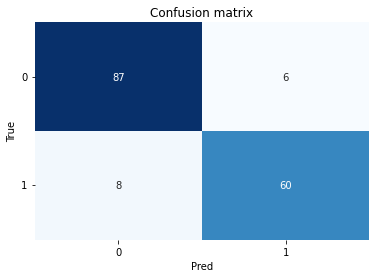

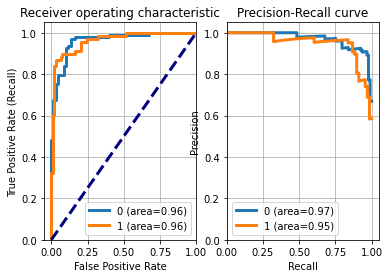

In [100]:
classes = np.unique(y_test_)
y_test_array = pd.get_dummies(y_test_, drop_first=False).values
    
## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test_, predicted)
auc = metrics.roc_auc_score(y_test_, predicted, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test_, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test_, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2)
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

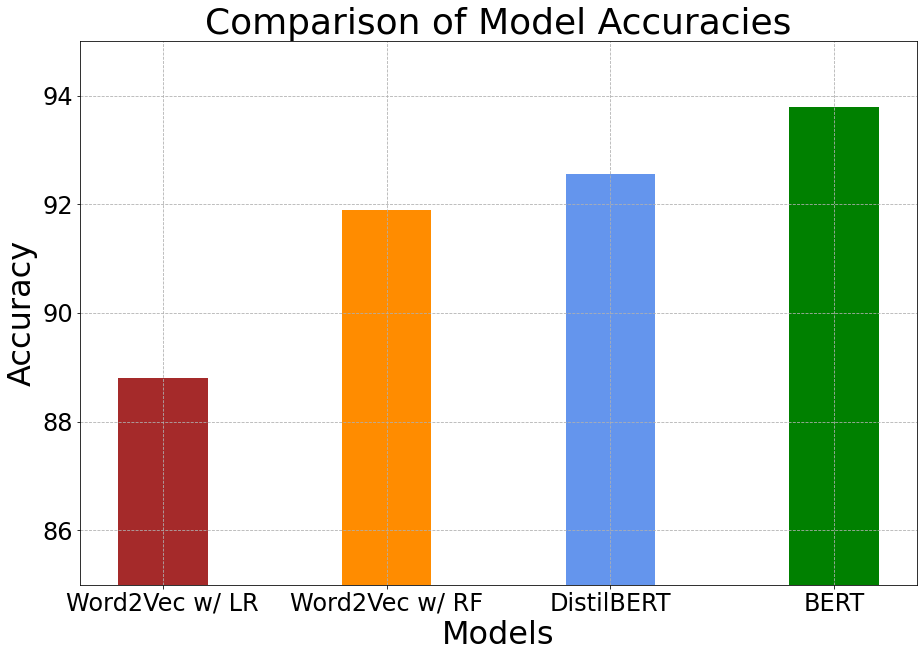

In [122]:
data = {'Word2Vec w/ LR': 88.8, 'Word2Vec w/ RF': 91.9, 'DistilBERT': 92.55, 'BERT':93.79}
models = list(data.keys())
values = list(data.values())
plt.figure(figsize=(15, 10))
plt.bar(models, values, color=['brown', 'darkorange', 'cornflowerblue', 'green'],
        width = 0.4)
plt.xlabel("Models", fontsize=32)
plt.ylabel("Accuracy", fontsize=32)
plt.title("Comparison of Model Accuracies", fontsize=36)
plt.grid(linestyle="--")
# plt.tight_layout()
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.ylim(85, 95)
plt.savefig('results.png')
plt.show()